In [34]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

In [35]:
chunksize = 10000
reader = pd.read_csv(
    "/data/hmn_data/alibaba_cluster_data/MSRTQps_sort.csv", chunksize=chunksize)


In [36]:
df = pd.DataFrame()
index = 0
# 循环读取每个数据块并添加到DataFrame中
for chunk in reader:
    if index>10:
        break
    else:
        index += 1
    df = pd.concat([df, chunk])

In [52]:
df.shape

(110000, 5)

In [38]:
# 定义步长 K
TIME_STEP = 10


def split_array_by_step(arr, k):
    return [arr[i:i+k] for i in range(0, len(arr)-k, k)]

# 按照 msinstanceid 列分组
grouped_df = df.groupby('msinstanceid')["HTTP_RT"].apply(
    lambda x: split_array_by_step(x, TIME_STEP+1)).reset_index()


In [39]:
combined_df = pd.DataFrame()

# 对于每个分组
for index, row in grouped_df.iterrows():
    if len(row["HTTP_RT"]) > 0:
        combined_df = pd.concat([combined_df, pd.DataFrame(
            np.stack([arr for arr in row["HTTP_RT"]], axis=0))])

print(combined_df.shape)

(9907, 11)


In [40]:
scaler = MinMaxScaler()
workload = scaler.fit_transform(combined_df)

In [41]:
# 将数据转换为LSTM模型的输入形式
def create_sequences(data, time_steps=1):
    xs, ys = [], []
    for i in range(len(data)):
        xs.append(data[i][:time_steps])
        ys.append(data[i][time_steps])
    return np.array(xs), np.array(ys)

x_train, y_train = create_sequences(workload, TIME_STEP)

In [42]:
x_train=np.expand_dims(x_train, axis=2)

print(x_train.shape)
print(y_train.shape)

(9907, 10, 1)
(9907,)


In [43]:
train_size = int(len(x_train) * 0.8)
val_size = len(x_train) - train_size

x_train, x_val = x_train[0:train_size, :,
                         :], x_train[train_size:len(x_train), :, :]
y_train, y_val = y_train[0:train_size], y_train[train_size:len(y_train)]


In [44]:
INPUT_DIM = x_train.shape[2]
print(x_train.shape)
output_dim = 1
batch_size = 10 #每轮训练模型时，样本的数量
epochs = 50 #训练60轮次
hidden_size = 128
lstm_units = 64

(7925, 10, 1)


In [45]:
class Attention(nn.Module):
    def __init__(self, lstm_hidden_size, attention_size):
        super(Attention, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.attention_size = attention_size
        self.attention_vec = nn.Linear(lstm_hidden_size * 2, attention_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, lstm_out):
        attention_probs = self.sigmoid(self.attention_vec(lstm_out))
        return attention_probs * lstm_out


In [46]:

class LSTM_fun_PyTorch_att(nn.Module):
    def __init__(self, n_input, seq_len, lstm_hidden_size=32, attention_size=64):
        super(LSTM_fun_PyTorch_att, self).__init__()
        self.conv1d = nn.Conv1d(n_input, 32, kernel_size=1)
        self.relu = nn.ReLU()
        self.maxpool1d = nn.MaxPool1d(seq_len)
        self.dropout = nn.Dropout(0.1)
        self.bilstm = nn.LSTM(32, lstm_hidden_size, bidirectional=True)
        self.attention = Attention(lstm_hidden_size, attention_size)
        self.fc = nn.Linear(lstm_hidden_size * 2, 1)

    def forward(self, inputs):
        x = self.conv1d(inputs)
        x = self.relu(x)
        x = self.maxpool1d(x)
        x = self.dropout(x)
        x = x.transpose(1, 2)
        lstm_out, _ = self.bilstm(x)
        attention_mul = self.attention(lstm_out)
        output = self.fc(attention_mul)
        return output.squeeze()


In [47]:
def train_model(train_x, train_y, model, epochs, batch_size, device):
    train_x = torch.tensor(train_x, dtype=torch.float32).to(device)
    train_y = torch.tensor(train_y, dtype=torch.float32).to(device)
    dataset = TensorDataset(train_x, train_y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    for epoch in range(epochs):
        running_loss = 0.0
        total_samples = 0

        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_x.size(0)
            total_samples += batch_x.size(0)

        epoch_loss = running_loss / total_samples
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

    return model


In [48]:

def predict(model, predict_x, device):
    predict_x = torch.tensor(predict_x, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        y_pred = model(predict_x)
    return y_pred.cpu().numpy()


In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTM_fun_PyTorch_att(INPUT_DIM, TIME_STEP).to(device)

# Reshape the data to match the expected input format of nn.Conv1d
x_train = np.transpose(x_train, (0, 2, 1))
x_val = np.transpose(x_val, (0, 2, 1))


trained_model = train_model(x_train, y_train, model, epochs, batch_size, device)



(7925, 1, 10)
(7925,)
Epoch 1/50, Loss: 0.0004
Epoch 2/50, Loss: 0.0003
Epoch 3/50, Loss: 0.0003
Epoch 4/50, Loss: 0.0003
Epoch 5/50, Loss: 0.0002
Epoch 6/50, Loss: 0.0002
Epoch 7/50, Loss: 0.0002
Epoch 8/50, Loss: 0.0002
Epoch 9/50, Loss: 0.0002
Epoch 10/50, Loss: 0.0002
Epoch 11/50, Loss: 0.0002
Epoch 12/50, Loss: 0.0002
Epoch 13/50, Loss: 0.0002
Epoch 14/50, Loss: 0.0002
Epoch 15/50, Loss: 0.0002
Epoch 16/50, Loss: 0.0002
Epoch 17/50, Loss: 0.0002
Epoch 18/50, Loss: 0.0002
Epoch 19/50, Loss: 0.0002
Epoch 20/50, Loss: 0.0002
Epoch 21/50, Loss: 0.0002
Epoch 22/50, Loss: 0.0002
Epoch 23/50, Loss: 0.0002
Epoch 24/50, Loss: 0.0002
Epoch 25/50, Loss: 0.0002
Epoch 26/50, Loss: 0.0002
Epoch 27/50, Loss: 0.0002
Epoch 28/50, Loss: 0.0002
Epoch 29/50, Loss: 0.0002
Epoch 30/50, Loss: 0.0002
Epoch 31/50, Loss: 0.0002
Epoch 32/50, Loss: 0.0002
Epoch 33/50, Loss: 0.0002
Epoch 34/50, Loss: 0.0002
Epoch 35/50, Loss: 0.0002
Epoch 36/50, Loss: 0.0002
Epoch 37/50, Loss: 0.0002
Epoch 38/50, Loss: 0.0002

In [1]:
def plot_predictions(y_val, y_pred):
    plt.figure(figsize=(12, 6))
    plt.ylim(0, 0.1)
    plt.plot(y_val, label="Actual Values", color='blue')
    plt.plot(y_pred, label="Predicted Values", color='red')
    plt.xlabel("Timestamp")
    plt.ylabel("Workload")
    plt.legend()
    plt.show()

y_pred = predict(trained_model, x_val, device)

NameError: name 'predict' is not defined

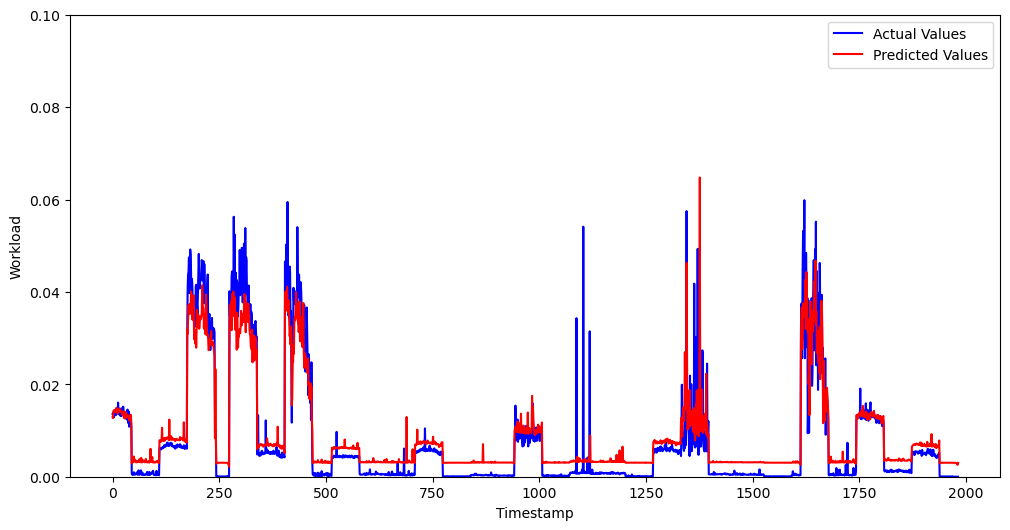

In [56]:
plot_predictions(y_val, y_pred)